# Logistic Regression
## Introduction

In this notebook we are going to study gradient descent and in this case applied to logistic regression.
Logistic regression (LR) is a statistical method for analysing datasets where there are one of more independent variables that determine the outcome. The outcome is a dichotomous, meaning there are only two possible outcomes (1 / 0, Yes / No, True / False). For instance, if you want to predict the sex of a person from age ($x_1$) and income ($x_2$), the logistic regression model would be

$$ h(x) = \theta_0 + \theta_1x_1 + \theta_2 x_2 $$

where $h(x)$ is the outcome varibale, $\theta_0$ the bias and $\theta_1$ and $\theta_2$ the weights. The goal is ultimately to tune these parameters with respect to the obeserved data ($x_1$,$x_2$).

LR estimates a probability (between 0 and 100%) but $h(x)$ gives values in $(-\infty, +\infty)$. We need to "squish" $h(x)$ to restrict it to a suitable range. LR commonly uses the logistic function (a.k.a. sigmoid function) to compute probabilities: 

$$ \sigma(h(x)) = \frac{1}{1+e^{-h(x)}}. $$

It is possible to threshold the logistic function (values between 0-1), and values below 0.5 will be counted as the prediction of class 0 and values larger than 0.5 results in the prediction of class 1.

The full logistic regression model is then:

$$ z(x) = \sigma(h(x)) = \frac{1}{1+e^{-(\theta_0 + \theta_1x_1 + \theta_2 x_2)}}. $$

# Ready, steady, code! 🚀

Let's start with loading some data, scikit-learn comes with a couple of toy datasets and we are going to use the "iris" dataset where the goal is to classify which type of flower based on a set of features consisting of sepal length (cm), sepal width (cm), petal length (cm), petal width (cm). To begin with we consider only two of those features.

In [14]:
# import stuff that we need
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
from IPython.display import clear_output # if you get problem with this import you can skip it, it is used to print the cost later which can be skipped

In [15]:
# I am running newer versions of all libraries. It seems to work fine.
assert np.__version__ >= "1.19.4", "Looks like you don't have the same version of numpy as us!"
assert mpl.__version__ >= "3.3.3", "Looks like you don't have the same version of matplotlib as us!"
assert sklearn.__version__ >= "0.24.0", "Looks like you don't have the same version of sklearn as us!"

In [16]:
data = ds.load_iris()

selected_features_idx = [0,1] #'sepal length (cm)', 'sepal width (cm)'
selected_targets = [0,1] #'setosa' 'versicolor'

idx = np.array([x in selected_targets for x in data.target])
x = data.data[:,selected_features_idx][idx]
y = data.target[idx]
y[y > 1] = 1 # Reset labels greater than 1 to 1

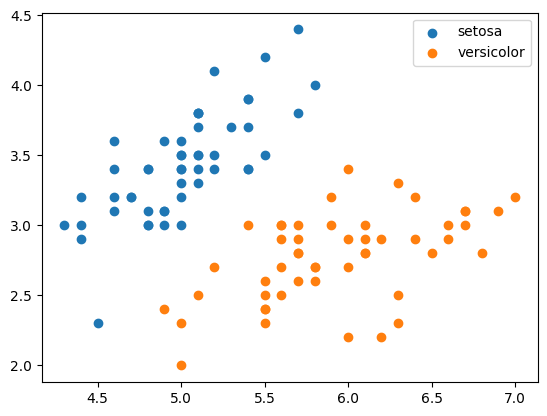

In [17]:
plt.figure()
for label in np.unique(y):
    plt.scatter(x[:, 0][y == label], x[:, 1][y == label], label = data.target_names[label])
plt.legend()
plt.show()

Now we need a function that predicts the logistic regression model and make predictions. This function takes a measurement, the current bias and the weights as input.

$$ z(x) = \frac{1}{1+e^{-(\theta_0 + \theta_1x_1 + \theta_2x_2)}} $$


In [18]:
def z_x(x, bias, weights):
    """ param x: vector containing measurements. x = [x1, x2]
        param bias: single value
        param weight: vector containing model weights. weights= [w1,w2]
        
        return: value of logistic regression model for defined x, bias and weights
    """
    return 1 / (1 + np.exp(-(bias + np.dot(x, weights))))

Now try it with some random weights and bias.

In [19]:
bias = np.random.normal()
weights = np.random.normal(size = len(x[0]))

# z_x is vectorized so it can be used for entire dataset
predicted = np.round(z_x(x, bias, weights))
#predicted = []
#for i in range(len(x)):
#    yhat = z_x(x[i], bias, weights)
#    predicted.append(round(yhat))

print('Accuracy: ', np.sum(np.equal(y, predicted)) / len(predicted))

Accuracy:  0.93


Let's plot the decision boundary between the points for this set of weights. The decision boundary is found by setting $h(x) = 0$ which gives:

$$ x_2 = -\frac{\theta_0 + \theta_1x_1}{\theta_2} $$

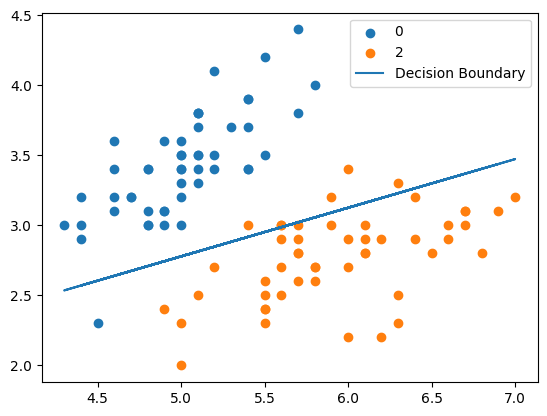

In [20]:
x_values = x[:,0]
y_values = - (bias + weights[0]*x_values) / weights[1]

plt.figure()
plt.scatter(x[:,0][y==0],x[:,1][y==0], label = '0')
plt.scatter(x[:,0][y==1],x[:,1][y==1], label = '2')
plt.plot(x_values, y_values, label='Decision Boundary')
plt.legend()
plt.show()

Not very good (or did you get lucky with the weights?). Try rerunning it a couple of times to see if you can randomly find a better set of weights that improves the accuracy.



Now, a better way of finding the optimal weights is the gradient descent method. Gradient descent is an iterative process of minimizing a function by following the gradients of a pre-defined cost function. This is useful for updating and tuning the parameters of our logistic regression model. As gradient descent is an iterative algorithm, we have to repeat the above step until we reach a satisfactory solution. The updates are defined as:

$$ \theta_j \leftarrow \theta_j - \alpha \frac{\partial J(\theta)}{\partial\theta_j}, $$

and similarily for the bias term 

$$ \theta_0 \leftarrow \theta_0 - \alpha \frac{\partial J(\theta)}{\partial \theta_o}. $$

Where $\alpha$ is a user specified learning rate, a scalar that controls the step size in the parameter space and $J(\theta)$ is the cost function that we will now define. Note that to minimize the cost function, we move in the direction opposite to the gradient.

First, we need to define our cost function, which is typically the negative log-likelihood of the data for numerical reasons, also called *Binary-Cross-Entropy* loss function. For a binary classification problem with $m$ training examples, where $x^{(i)}$ represents the $i$-th example of our training set and $y^{(i)}$ its output, the cost function is given by:

$$
J(\theta)=\frac{1}{m}\sum_{i=1}^m 
\begin{cases}
-log(g(x^{(i)}, \theta)),& \text{if } y^{(i)} = 1\\
-log(1 - g(x^{(i)},\theta)),& \text{if } y^{(i)} = 0
\end{cases}
$$

where $g(x^{(i)},\theta)$ modelizes $P(y = 1 | x; \theta)$. Note that we have added $\theta$ explicitly to the notation to emphasize the dependence on the model parameters.

The two functions can be combined into one as:

$$ J(\theta) = -\frac{1}{m} \sum_{i=1}^m [y^{(i)} \log(z_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - z_\theta(x^{(i)}))] $$

Where $z_θ(x)$ is the sigmoid function, representing the probability that the input $x$ belongs to the positive class.

To simplify the notation in the following calculations, we will omit the subindexes; nevertheless, keep in mind that when the cost function is optimized, it is done across all samples in the training dataset.

$$ J(\theta)= -y\cdot log(z(x)) - (1-y)\cdot log(1-z(x))$$

where $y$ is the target class. The Binary-Cross-Entropy tells us that if the target is 1 and we predict 0, then we will get a large error ($-log(0) = \infty$) and vice verca ($-log(1 - 1) = -log(0) = \infty$).

For gradient descent we need the derivative of this cost function with respect to the weights $\frac{\partial J(\theta)}{\partial\theta_j}$. We can get this with the chain rule:



$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{\partial J(\theta)}{\partial z(x)} \cdot \frac{\partial z(x)}{\partial h(x)} \cdot \frac{\partial h(x)}{\partial \theta_j}$$


Where the three derivatives result in:

$$\begin{aligned} \frac{\partial J(\theta)}{\partial z(x)} &= -\left(\frac{y}{z(x)} - \frac{(1-y)}{(1-z(x))}\right) \\ \frac{\partial z(x)}{\partial h(x)} &= z(x)\cdot(1-z(x)) \\ \frac{\partial h(x)}{\partial \theta} &=  x \end{aligned}$$

Combining the previous equations together with the previous chain rule gives 

$$ \frac{\partial J(\theta)}{\partial\theta_j} = x_j\cdot(z(x)-y) $$

where $x_j$ is the $j$-th component of $x$.

For the bias term the derivative is similar but it is not dependent on $x$ since $\frac{\partial h(x)}{\partial \theta_0} =  1$

$$ \frac{\partial J(\theta)}{\partial \theta_0} = z(x)-y $$

Finally, recovering the subindex notation for all the samples in our training set we can express the gradient of the cost function with respect to each parameter. For the weight case:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (z_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}. $$

And for the bias case:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (z_\theta(x^{(i)}) - y^{(i)}). $$

With this two formulas now we can use these gradients to update the parameters in the gradient descent algorithm.

**The full algorithm is:**
1. Initialize the weights randomly. 
2. Calculate the gradients of cost function w.r.t parameters.
3. Update the weights by $\theta_j \leftarrow \theta_j - \alpha \frac{\partial}{\partial \theta_j}J(\theta)$
4. Update the bias by $\theta_0 \leftarrow \theta_0 - \alpha \frac{\partial}{\partial \theta_0}J(\theta)$
5. Repeat until value of cost function does not change or to a pre-defined number of iterations.

Write a function for the cost and one for its derivative with respect to the weights and one with respect to the bias. Note that the derivative function will return the number of values corresponing the the number of weights that you have. Also note that we are only doing this for one training point.

In [21]:
def cost_function(y, x, bias, weights):
    """ param y: Ground truth label for measurements
        param x: vector containing measurements. x = [x1, x2]
        param bias: single value
        param weight: vector containing model weights. weights= [w1,w2]
    
        return: value of the cost function. In this case BCE
    """
    return -y * np.log(z_x(x, bias, weights)) - (1 - y) * np.log(1 - z_x(x, bias, weights))

In [27]:
def derivative_weights(y, x, bias, weights):
    """ param y: Ground truth label for measurements
        param x: vector containing measurements. x = [x1, x2]
        param bias: single value
        param weight: vector containing model weights. weights= [w1,w2]
    
        return: derivative of cost function with respect to the weights, dw = [dw1, dw2]
    """
    return np.array([x[:,0] * (z_x(x, bias, weights) - y), x[:,1] * (z_x(x, bias, weights) - y)])

SyntaxError: invalid syntax (3558327190.py, line 9)

In [23]:
def derivative_bias(y, x, bias, weights):
    """ param y: Ground truth label for measurements
        param x: vector containing measurements. x = [x1, x2]
        param bias: single value
        param weight: vector containing model weights. weights= [w1,w2]
    
        return: derivative of cost function with respect to the bias
    """
    return z_x(x, bias, weights) - y

Finally lets fit the logistic regression model with gradient descent across all training data points. As we saw before, gradient descent works by, at each iteration, average the total cost and the derivatives on over the full training set.

Implement gradient descent for logistic regression. Experiment with different learning rates and number of iterations to see if you get differnt solutions.

In [24]:


# Initialize weights and bias as random
bias = np.random.normal()
weights = np.random.normal(size = len(x[0]))

number_of_iterations = 100000 # <-- number of iterations to perform gradient descent

# Learning rate
lr = 1.5

cost = 0
for it in range(number_of_iterations + 1):
    # .. Code for gradient descent for logistic regression
    cost = np.mean(cost_function(y, x, bias, weights))
    weights -= lr * np.mean(derivative_weights(y, x, bias, weights), axis=1)
    bias -= lr * np.mean(derivative_bias(y, x, bias, weights))
    if it % 2000 == 0:
        print('iteration: ', it, ' cost: ', cost) # In this case the variable for the current cost is called "cost"



iteration:  0  cost:  1.119291685414622
iteration:  2000  cost:  0.03084844703353269
iteration:  4000  cost:  0.02206287642203097
iteration:  6000  cost:  0.017287361300995525
iteration:  8000  cost:  0.014309864661560246
iteration:  10000  cost:  0.012270428489172614
iteration:  12000  cost:  0.010781050490887796
iteration:  14000  cost:  0.009641510194806482
iteration:  16000  cost:  0.008738482821165895
iteration:  18000  cost:  0.008003139837434045
iteration:  20000  cost:  0.0073912652755596196
iteration:  22000  cost:  0.006873131205588764
iteration:  24000  cost:  0.0064279864224184025
iteration:  26000  cost:  0.006040884794090691
iteration:  28000  cost:  0.005700772362250228
iteration:  30000  cost:  0.005399286544244839
iteration:  32000  cost:  0.005129975950833303
iteration:  34000  cost:  0.004887778113098692
iteration:  36000  cost:  0.004668660600142372
iteration:  38000  cost:  0.004469368663821614
iteration:  40000  cost:  0.004287244125409438
iteration:  42000  cost:

In [25]:
#z_x is vectorized so it can be used for entire dataset
predicted = np.round(z_x(x, bias, weights))
#for i in range(len(x)):
#    yhat = z_x(x[i], bias, weights)
#    predicted.append(round(yhat))
print('Accuracy: ', np.sum(np.equal(y,predicted)) / len(predicted))

Accuracy:  1.0


Let us plot the decision boundary for the new weights:

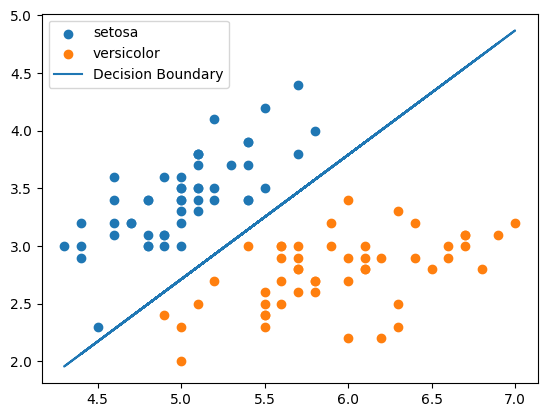

In [26]:
x_values = x[:,0]
y_values = - (bias + weights[0]*x_values) / weights[1]

plt.figure()
for label in np.unique(y):
    plt.scatter(x[:,0][y==label],x[:,1][y==label], label = data.target_names[label])
plt.plot(x_values, y_values, label='Decision Boundary')
plt.legend()
plt.show()